<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Trials

In [1]:
!pip install -q --upgrade optuna >/dev/null

In [2]:
import pandas as pd
import optuna
from optuna.storages import RDBStorage

## Connect Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Connect Database

https://optuna.readthedocs.io/en/stable/reference/generated/optuna.storages.RDBStorage.html#optuna.storages.RDBStorage

In [4]:
checkpoint = "distilbert-base-german-cased"
# checkpoint = "deepset/gbert-base"
# checkpoint = "deepset/gelectra-base"

db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"

storage = RDBStorage(
    url=f"sqlite:///{db_path}{db_name}.db",
    #engine_kwargs={"pool_size": 20, "connect_args": {"timeout": 10}},
)

## List Trials

In [5]:
for s in storage.get_all_study_summaries():
    if s.datetime_start is None:
        print(f"???        '{s.study_name}': {s.n_trials} Trials")
    else:
        print(f"{s.datetime_start.date()} '{s.study_name}': {s.n_trials} Trials")

2021-12-18 'deepset/gbert-base': 1 Trials
2021-12-18 'distilbert-base-german-cased': 89 Trials
???        '10kgnad_optuna': 0 Trials
2021-12-18 'distilbert-base-german-cased_bs32': 70 Trials


## Select a Study

In [6]:
study = checkpoint + "_bs32"
# study = storage.get_all_study_summaries()[0].study_name

trials = storage.get_all_trials(storage.get_study_id_from_name(study))

In [7]:
trials[2]

FrozenTrial(number=2, values=[0.6464439034461975], datetime_start=datetime.datetime(2021, 12, 18, 22, 10, 40, 369200), datetime_complete=datetime.datetime(2021, 12, 18, 22, 16, 3, 337011), params={'label_smoothing_factor': 0.010433138633857076, 'learning_rate': 1.948765621949202e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 32, 'weight_decay': 0.001887314639743122}, distributions={'label_smoothing_factor': UniformDistribution(high=0.1, low=0.0), 'learning_rate': LogUniformDistribution(high=0.0001, low=1e-05), 'num_train_epochs': CategoricalDistribution(choices=(1,)), 'per_device_train_batch_size': CategoricalDistribution(choices=(32,)), 'weight_decay': LogUniformDistribution(high=0.01, low=0.001)}, user_attrs={'eval_acc': 0.8326848249027238, 'eval_f1': 0.8291801913909373, 'eval_loss': 0.6464439034461975, 'eval_precision': 0.8375314137540264, 'eval_recall': 0.8228964113735854, 'eval_runtime': 9.5346, 'eval_samples_per_second': 107.818, 'eval_steps_per_second': 3.461}, syste

In [8]:
from optuna.trial import TrialState

complete_trials = [t for t in trials if t.state==TrialState.COMPLETE]

trial_df = pd.DataFrame([t.params for t in complete_trials])
trial_df.index = [t.number for t in complete_trials]
trial_df["eval_loss"] = [t.value for t in complete_trials]

userattr_df = pd.DataFrame([t.user_attrs for t in complete_trials])
userattr_df.index = [t.number for t in complete_trials]
metrics_df = pd.concat([trial_df.drop("eval_loss", axis=1), userattr_df], axis=1)

metrics_df.sort_values("eval_loss")

,label_smoothing_factor,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_acc,eval_f1,eval_loss,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second
67,0.000622,0.000092,1,32,0.003329,0.880350,0.879231,0.371454,0.880686,0.878219,9.5703,107.415,3.448
66,0.000475,0.000091,1,32,0.003401,0.876459,0.874977,0.371626,0.877185,0.873415,9.5706,107.412,3.448
62,0.000157,0.000091,1,32,0.002396,0.878405,0.876140,0.372342,0.875595,0.877201,9.5401,107.756,3.459
64,0.000516,0.000091,1,32,0.002564,0.874514,0.873946,0.375510,0.873540,0.874693,9.5854,107.247,3.443
63,0.000593,0.000091,1,32,0.002436,0.874514,0.872767,0.376597,0.872944,0.872910,9.5519,107.622,3.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.007080,0.000012,1,32,0.001102,0.780156,0.757565,0.869488,0.788226,0.743655,9.5503,107.641,3.455
4,0.015827,0.000012,1,32,0.001647,0.772374,0.747679,0.914909,0.781048,0.732878,9.5102,108.094,3.470
46,0.093512,0.000015,1,32,0.001123,0.814202,0.808696,0.945324,0.822882,0.798714,9.6462,106.571,3.421
47,0.011318,0.000010,1,32,0.001790,0.749027,0.711397,0.983490,0.760912,0.694870,9.6183,106.880,3.431


In [9]:
metrics_df.per_device_train_batch_size.value_counts()

32    70
Name: per_device_train_batch_size, dtype: int64

In [10]:
import plotly.express as px
fig = px.parallel_coordinates(trial_df, color="eval_loss", 
                             color_continuous_scale=px.colors.sequential.Oryel)
fig.show()

In [11]:
study = optuna.create_study(study_name=study,
                            storage=f"sqlite:///{db_path}{db_name}.db",
                            load_if_exists=True,)

[I 2021-12-19 07:49:38,238] Using an existing study with name 'distilbert-base-german-cased_bs32' instead of creating a new one.


In [12]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="eval_loss"
)

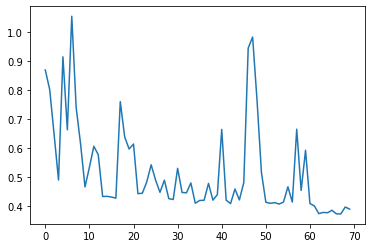

In [13]:
trial_df.eval_loss.plot();

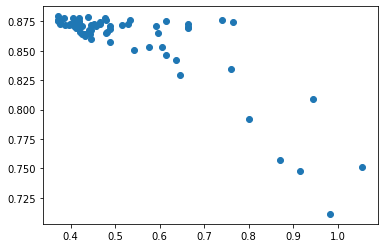

In [14]:
import matplotlib.pyplot as plt
plt.scatter(metrics_df.eval_loss, metrics_df.eval_f1);